In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Подсказка, чтобы не забыть смысл столбцов

# row_id: (int64) ID code for the row.
# timestamp: (int64) the time in milliseconds between this user interaction and the first event completion from that user.
# user_id: (int32) ID code for the user.
# content_id: (int16) ID code for the user interaction
# content_type_id: (int8) 0 if the event was a question being posed to the user, 1 if the event was the user watching a lecture.
# task_container_id: (int16) Id code for the batch of questions or lectures.
#                            For example, a user might see three questions in a row before seeing the explanations
#                            for any of them. Those three would all share a task_container_id.
# user_answer: (int8) the user's answer to the question, if any. Read -1 as null, for lectures.
# answered_correctly: (int8) if the user responded correctly. Read -1 as null, for lectures.
# prior_question_elapsed_time: (float32) The average time in milliseconds it took a user to answer each question
#                                        in the previous question bundle, ignoring any lectures in between.
#                                        Is null for a user's first question bundle or lecture.
#                                        Note that the time is the average time a user took to solve each question
#                                        in the previous bundle.
# prior_question_had_explanation: (bool) Whether or not the user saw an explanation and the correct response(s) after
#                                        answering the previous question bundle, ignoring any lectures in between.
#                                        The value is shared across a single question bundle,
#                                        and is null for a user's first question bundle or lecture.
#                                        Typically the first several questions a user sees were part of an onboarding
#                                        diagnostic test where they did not get any feedback.

In [3]:
# Загружаем основной датасет
# При загрузке преобразовываем типы к указанным в описании для уменьшения размера
# Опускаем при загрузке столбец:
# 'row_id' - содержит избыточную информацию т.к. каждая строка датафрейма нумеруется по умолчанию

train_data = pd.read_csv('data/train.csv',
                         usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                         dtype={
                             'timestamp': 'int64',
                             'user_id': 'int32',
                             'content_id': 'int16',
                             'content_type_id': 'int8',
                             'task_container_id': 'int16',
                             'user_answer': 'int8',
                             'answered_correctly':'int8',
                             'prior_question_elapsed_time': 'float32',
                             'prior_question_had_explanation': 'boolean'
                         })

In [4]:
# Копируем датафрейм, чтобы не загружать заново в случае ошибки
# Выводим первые 5 строк для лучшего понимания данных

train_df = train_data.copy()
train_df.head()

,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,0,1,3,1,NaN,<NA>
1,56943,115,5716,0,2,2,1,37000.0,False
2,118363,115,128,0,0,0,1,55000.0,False
3,131167,115,7860,0,3,0,1,19000.0,False
4,137965,115,7922,0,4,1,1,11000.0,False


In [5]:
# Выводим базовую информацию. Делаем выводы:
# 1. В столбцах 'prior_question_elapsed_time' и 'prior_question_had_explanation'
#    имеются пустые значения, их смысл ясен из описания столбцов
# 2. В остальных столбцах пустых значений нет.
# 3. Всего в датасете 101230332 строк

train_df.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101230332 entries, 0 to 101230331
Data columns (total 9 columns):
 #   Column                          Non-Null Count      Dtype  
---  ------                          --------------      -----  
 0   timestamp                       101230332 non-null  int64  
 1   user_id                         101230332 non-null  int32  
 2   content_id                      101230332 non-null  int16  
 3   content_type_id                 101230332 non-null  int8   
 4   task_container_id               101230332 non-null  int16  
 5   user_answer                     101230332 non-null  int8   
 6   answered_correctly              101230332 non-null  int8   
 7   prior_question_elapsed_time     98878794 non-null   float32
 8   prior_question_had_explanation  100837826 non-null  boolean
dtypes: boolean(1), float32(1), int16(2), int32(1), int64(1), int8(3)
memory usage: 2.4 GB


In [6]:
# Выделяем в отдельный датафрейм информацию по лекциям
# Не копируем столбцы, относящиеся только к вопросам, и столбец с признаком лекции 'content_type_id'

train_lectures = train_df.loc[train_df['content_type_id'] == 1,
                              ['timestamp',
                               'user_id',
                               'content_id',
                               'task_container_id']
                             ]
train_lectures.head()

,timestamp,user_id,content_id,task_container_id
89,653762,2746,6808,14
117,10183847,5382,16736,21
212,1424348597,5382,30207,104
216,1425557777,5382,18545,121
295,405813029,8623,10540,59


In [7]:
# Выделяем в отдельный датафрейм информацию по вопросам
# Удаляем столбец с признаком вопроса 'content_type_id'

train_questions = train_df.loc[train_df['content_type_id'] == 0]
train_questions = train_questions.drop(columns=['content_type_id'])
train_questions.head()

,timestamp,user_id,content_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,1,3,1,NaN,<NA>
1,56943,115,5716,2,2,1,37000.0,False
2,118363,115,128,0,0,1,55000.0,False
3,131167,115,7860,3,0,1,19000.0,False
4,137965,115,7922,4,1,1,11000.0,False


In [8]:
# Работаем с отдельным датафреймом по лекциям

In [9]:
# Подсказка, чтобы не забыть смысл столбцов

# lecture_id: foreign key for the train/test content_id column, when the content type is lecture (1).
# part: top level category code for the lecture.
# tag: one tag codes for the lecture.
#      The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
# type_of: brief description of the core purpose of the lecture.

In [10]:
# Загружаем датасет с характеристиками лекций
lectures_data = pd.read_csv('data/lectures.csv', sep=',')

In [11]:
# Копируем датафрейм, чтобы не загружать заново в случае ошибки
# Выводим первые 5 строк для лучшего понимания данных

lectures_df = lectures_data.copy()
lectures_df.head()

,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question


In [12]:
# Выводим базовую информацию. Делаем выводы:
# 1. В датафрейме отсутствуют столбцы с пустыми значениями;
# 2. Возможно столбцы 'lecture_id', 'tag' и 'part' имеет смысл позже преобразовать в другой тип
#    чтобы не занимать лишнюю память;
# 3. Столбец 'type_of' вероятно можно будет использователь для категоризации просмотров лекций.

lectures_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


In [13]:
# Выводим базовую статистику, делаем выводы на основе максимальных и минимальных значений полей:
# 1. столбец 'lecture_id' может быть преобразован в тип uint16;
# 2. столбец 'tag' может быть преобразован в тип uint8;
# 3. столбец 'part' может быть преобразован в тип uint8 или category.
# 4. всего в датасете 418 лекций.

lectures_df.describe()

,lecture_id,tag,part
count,418.000000,418.000000,418.000000
mean,16983.401914,94.480861,4.267943
std,9426.164660,53.586487,1.872424
min,89.000000,0.000000,1.000000
25%,9026.250000,50.250000,2.000000
50%,17161.500000,94.500000,5.000000
75%,24906.250000,140.000000,6.000000
max,32736.000000,187.000000,7.000000


In [14]:
# Создаем переменную с количеством лекций (418)

number_of_lectures = lectures_df['lecture_id'].nunique()
number_of_lectures

418

In [15]:
# Выводим информацию о значениях столбца 'type_of' и частоте их появления. Делаем выводы:
# 1. Всего представлено 4 типа лекций;
# 2. Наиболее часто встречаются концептуальные лекции (concept, 222 раза)
#    и лекции, посвященные решению вопроса (solving question, 186 раз);
# 3. Столбец, при нобходимости, можно будет преобразовать в тип 'category';
# 4. Можно попробовать объединить цели 'intention' и 'starter' в одну категорию 'other', 
#    но поскольку мы не знаем, какую информацию они несут, лучше их оставить
#    т.к. могут пригодиться в будущем при обучении моделей.

lectures_df['type_of'].value_counts()

concept             222
solving question    186
intention             7
starter               3
Name: type_of, dtype: int64

In [16]:
# Выводим информацию о значениях столбца 'part' и частоте их появления. Делаем выводы:
# 1. Всего представлено 7 разных частей;
# 2. Наиболее часто встречаются лекции из части 5 (143 раза);
# 3. Столбец можно использовать для категоризации лекций

lectures_df['part'].value_counts()

5    143
6     83
2     56
1     54
7     32
4     31
3     19
Name: part, dtype: int64

In [17]:
# Выводим информацию о значениях столбца 'tag' и частоте их появления. Делаем выводы:
# 1. Всего представлен 151 тег;
# 2. В перспективе вероятно теги можно будет использовать для категоризации лекций

lectures_df['tag'].value_counts()

136    7
27     6
161    6
74     6
134    6
      ..
90     1
112    1
31     1
138    1
2      1
Name: tag, Length: 151, dtype: int64

In [18]:
# По идентификаторам объединяем информацию о конкретных лекциях с информацией о студентах, их прослушавших
# Удаляем дублирующий столбец с идентификатором

train_lectures = train_lectures.merge(lectures_data,
                                      left_on='content_id',
                                      right_on='lecture_id')
train_lectures = train_lectures.drop(columns=['content_id'])
train_lectures.head()

,timestamp,user_id,task_container_id,lecture_id,tag,part,type_of
0,653762,2746,14,6808,129,2,intention
1,1623661788,24418,121,6808,129,2,intention
2,600004996,91216,312,6808,129,2,intention
3,2461208170,138650,182,6808,129,2,intention
4,10318788851,166728,331,6808,129,2,intention


In [19]:
# Создаем новый датафрейм с количеством просмотров лекций каждого типа для каждого студента
# Добавляем столбец с общим количеством лекций, промотренных студентом

users_lectures = pd.pivot_table(
    train_lectures,
    values='lecture_id',
    index='user_id',
    columns='type_of',
    aggfunc='count',
    fill_value=0
).reset_index()
users_lectures['user_total_lect'] = users_lectures['concept']
users_lectures['user_total_lect'] += users_lectures['intention']
users_lectures['user_total_lect'] += users_lectures['solving question']
users_lectures['user_total_lect'] += users_lectures['starter']
users_lectures = users_lectures.rename(
    columns={'concept': 'lect_type_of_concept',
             'intention': 'lect_type_of_intention',
             'solving question': 'lect_type_of_solving',
             'starter': 'lect_type_of_starter'}
)
users_lectures

type_of,user_id,lect_type_of_concept,lect_type_of_intention,lect_type_of_solving,lect_type_of_starter,user_total_lect
0,2746,0,1,0,0,1
1,5382,3,0,0,0,3
2,8623,3,0,0,0,3
3,12741,4,0,2,0,6
4,13134,6,1,0,0,7
...,...,...,...,...,...,...
149601,2147419988,27,0,17,0,44
149602,2147469944,3,0,0,0,3
149603,2147470770,2,0,0,0,2
149604,2147470777,6,0,0,0,6


In [20]:
# Создаем новый датафрейм с количеством просмотров лекций из каждой части для каждого студента
# Объединяем с прошлым датафреймом, получаем общий датафрейм с просмотрами лекций каждым студентом по типам и частям

grouped_lectures_part = pd.pivot_table(
    train_lectures,
    values='lecture_id',
    index='user_id',
    columns='part',
    aggfunc=len,
    fill_value=0
).reset_index()
grouped_lectures_part = grouped_lectures_part.rename(
    columns={1: 'lect_part_1',
             2: 'lect_part_2',
             3: 'lect_part_3',
             4: 'lect_part_4',
             5: 'lect_part_5',
             6: 'lect_part_6',
             7: 'lect_part_7'}
)
users_lectures = users_lectures.merge(grouped_lectures_part,
                                      how='left',
                                      on='user_id')
users_lectures

,user_id,lect_type_of_concept,lect_type_of_intention,lect_type_of_solving,lect_type_of_starter,user_total_lect,lect_part_1,lect_part_2,lect_part_3,lect_part_4,lect_part_5,lect_part_6,lect_part_7
0,2746,0,1,0,0,1,0,1,0,0,0,0,0
1,5382,3,0,0,0,3,1,0,0,0,2,0,0
2,8623,3,0,0,0,3,2,1,0,0,0,0,0
3,12741,4,0,2,0,6,0,0,0,3,0,1,2
4,13134,6,1,0,0,7,1,3,0,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
149601,2147419988,27,0,17,0,44,4,0,1,0,18,21,0
149602,2147469944,3,0,0,0,3,1,0,0,1,1,0,0
149603,2147470770,2,0,0,0,2,0,0,0,0,2,0,0
149604,2147470777,6,0,0,0,6,0,0,0,3,3,0,0


In [21]:
# Выведем 10 студентов, просмотревших наибольшее количество лекций

users_lectures[['user_id', 'user_total_lect']].sort_values(by='user_total_lect',
                                                           ascending=False
                                                          ).head(10)

,user_id,user_total_lect
25855,372519499,397
24520,353540103,395
7334,105239469,389
74114,1066383521,386
143920,2066672014,386
13453,194669131,385
77047,1109748920,379
34658,499347415,377
115464,1660941992,368
42917,617553217,363


In [22]:
# Выведем 10 студентов, просмотревших наибольшее количество концептуальных лекций

users_lectures[['user_id', 'lect_type_of_concept']].sort_values(by='lect_type_of_concept',
                                                           ascending=False
                                                          ).head(10)

,user_id,lect_type_of_concept
24520,353540103,203
25855,372519499,201
143920,2066672014,199
7334,105239469,199
13453,194669131,198
42917,617553217,198
74114,1066383521,197
115464,1660941992,194
77047,1109748920,193
34658,499347415,191


In [23]:
# Выведем 10 студентов, просмотревших наибольшее лекций с разбором решений

users_lectures[['user_id', 'lect_type_of_solving']].sort_values(by='lect_type_of_solving',
                                                           ascending=False
                                                          ).head(10)

,user_id,lect_type_of_solving
25855,372519499,189
24520,353540103,185
74114,1066383521,184
7334,105239469,183
143920,2066672014,181
13453,194669131,180
34658,499347415,179
77047,1109748920,179
115464,1660941992,168
42917,617553217,158


In [24]:
# Работаем с отдельным датафреймом по вопросам

In [25]:
# Подсказка, чтобы не забыть смысл столбцов

# question_id: foreign key for the train/test content_id column, when the content type is question (0).
# bundle_id: code for which questions are served together.
# correct_answer: the answer to the question.
#                 Can be compared with the train user_answer column to check if the user was right.
# part: the relevant section of the TOEIC test.
# tags: one or more detailed tag codes for the question.
#       The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

In [26]:
# Загружаем датасет с вопросами

questions_data = pd.read_csv('data/questions.csv', sep=',')

In [27]:
# Копируем датафрейм, чтобы не загружать заново в случае ошибки
# Выводим первые 5 строк для лучшего понимания данных

questions_df = questions_data.copy()
questions_df.head()

,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38


In [28]:
# Выводим базовую информацию. Делаем выводы:
# 1. В столбце 'tags' есть одна ячейка с пустым значением;
# 2. Возможно столбцы 'bundle_id', 'correct_answer' и 'part' имеет смысл преобразовать
#    в другой тип, чтобы не занимать лишнюю память;
# 3. Столбцы 'bundle_id' и 'part' возможно можно будет использовать для категоризации ответов студентов;
# 4. Возможно столбец 'tags' вероятно нужно будет раскрыть.

questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


In [29]:
# Выводим базовую статистику, делаем выводы на основе максимальных и минимальных значений полей:
# 1. столбцы 'question_id' и bundle_id' можгут быть преобразованы в тип uint16;
# 2. столбцы 'correct_answer' и 'part' могут быть преобразованы в тип uint8;
# 3. всего в датасете 13523 вопроса.

questions_df.describe()

,question_id,bundle_id,correct_answer,part
count,13523.00000,13523.000000,13523.000000,13523.000000
mean,6761.00000,6760.510907,1.455298,4.264956
std,3903.89818,3903.857783,1.149707,1.652553
min,0.00000,0.000000,0.000000,1.000000
25%,3380.50000,3379.500000,0.000000,3.000000
50%,6761.00000,6761.000000,1.000000,5.000000
75%,10141.50000,10140.000000,3.000000,5.000000
max,13522.00000,13522.000000,3.000000,7.000000


In [30]:
# Создаем переменную с количеством уникальных вопросов (13523)

number_of_questions = questions_df['question_id'].nunique()
number_of_questions

13523

In [31]:
# Выводим информацию о значениях столбца 'part' и частоте их появления. Делаем выводы:
# 1. Всего представлено 7 разных частей, которые вероятно коррелируют с 7 частями лекций;
# 2. Наиболее часто встречаются вопросы из лекции части 5 (5511 вопросов);
# 3. Порядок сортировки частей по количеству вопросов отличается от аналогичной
#    сортировки по количеству лекций. Части с наиобольшим количеством лекций не обязательно соответствует
#    часть с наибольшим количеством вопросов.

questions_parts_quantity = questions_df['part'].value_counts()
questions_parts_quantity

5    5511
2    1647
3    1562
4    1439
6    1212
7    1160
1     992
Name: part, dtype: int64

In [32]:
# Выводим информацию о значениях столбца 'bundle_id' и частоте их появления. Делаем выводы:
# 1. Всего представлено 9765 разных блоков вопросов;
# 2. Будет проблематично использовать блоки в качестве категорий.

questions_df['bundle_id'].value_counts()

8034     5
7790     5
7260     5
7195     5
7190     5
        ..
5058     1
5057     1
5056     1
5055     1
13522    1
Name: bundle_id, Length: 9765, dtype: int64

In [33]:
# Пишем функцию, которая преобразовывает строку тегов в список и применяем ее

def get_tags_as_list(tags):
    return str(tags).split(' ')

questions_df['new_tags'] = questions_df['tags'].apply(get_tags_as_list)
questions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
 5   new_tags        13523 non-null  object
dtypes: int64(4), object(2)
memory usage: 634.0+ KB


In [34]:
# Раскрываем списки тегов.
# Видим, что всего есть 30993 тега

questions_df_tags = questions_df.explode('new_tags')['new_tags']
questions_df_tags

0         51
0        131
0        162
0         38
1        131
        ... 
13518     14
13519      8
13520     73
13521    125
13522     55
Name: new_tags, Length: 30993, dtype: object

In [35]:
# Однако больше 90% вопросов относятся к 100 первым по частоте тегах

questions_df_tags.value_counts(normalize=True).nlargest(100).sum()

0.9269512470557867

In [36]:
# Выводим информацию о количестве правильных ответов каждого для пользователей
# Сортируем по убыванию
# Ранее было показано, что количество правильных вопросов 13523
# Из полученных данных видно, что у двух пользователей число правильных ответов больше числа вопросов

users_answers = train_questions.groupby('user_id').agg(
    correct_answers_number=('answered_correctly', 'sum')
).reset_index()
users_answers.sort_values(by='correct_answers_number', ascending=False).head(10)

,user_id,correct_answers_number
392133,2139561972,14300.0
295612,1615528747,13678.0
61749,338684437,13416.0
337432,1842816145,13086.0
191252,1047202059,13034.0
83208,455973631,12840.0
270365,1478712595,12840.0
145895,801103753,12698.0
319095,1743444187,12644.0
379255,2070068957,12225.0


In [37]:
# Отсюда следуюет, что вероятно в датасете присутствую случаи, когда студент несколько раз
# давал правильный ответ на одну задачу. Такие варианты будут искажать количество правильных ответов студента
# и их нужно исключить. Сначала проверяем столбец 'answered_correctly' на наличие в нем ошибок

In [38]:
# По идентификаторам объединяем информацию о конкретных вопросах с информацией об ответах студентов
# Удаляем дублирующий столбец с идентификатором и столбец с нераскрытыми тегами
# Для проверки правильности столбца с корректностью ответов создаем новый столбец корректности,
# на основе сравнения ответов пользователя с ответами из датасета с вопросами
# и сравниваем его с заданным столбцом корректности.

train_questions = train_questions.merge(questions_df,
                                      left_on='content_id',
                                      right_on='question_id')
train_questions = train_questions.drop(columns=['content_id',
                                               'tags'])

train_questions['new_answered_correctly'] = np.where(
    train_questions['user_answer'] == train_questions['correct_answer'], 1, 0) 

train_questions['check_answered_correctly'] = np.where(
    train_questions['answered_correctly'] == train_questions['new_answered_correctly'], 0, 1) 

train_questions.head()

,timestamp,user_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,correct_answer,part,new_tags,new_answered_correctly,check_answered_correctly
0,0,115,1,3,1,NaN,<NA>,5692,5692,3,5,[151],1,0
1,4216576228,24418,497,3,1,21000.0,True,5692,5692,3,5,[151],1,0
2,0,51285,0,3,1,NaN,<NA>,5692,5692,3,5,[151],1,0
3,330907575,91216,153,3,1,22000.0,True,5692,5692,3,5,[151],1,0
4,560202977,138650,122,3,1,18000.0,True,5692,5692,3,5,[151],1,0


In [39]:
# Правильность столбца корректности ответов проверяем через суммирование данных в столбце проверки
# Сумма равна нулю, столбце корректности верен

train_questions['check_answered_correctly'].sum()

0

In [40]:
# Удаляем ненужные столбцы

train_questions = train_questions.drop(columns=['correct_answer',
                              'user_answer',
                              'new_answered_correctly',
                             'check_answered_correctly']
                    )
train_questions.head()

,timestamp,user_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,question_id,bundle_id,part,new_tags
0,0,115,1,1,NaN,<NA>,5692,5692,5,[151]
1,4216576228,24418,497,1,21000.0,True,5692,5692,5,[151]
2,0,51285,0,1,NaN,<NA>,5692,5692,5,[151]
3,330907575,91216,153,1,22000.0,True,5692,5692,5,[151]
4,560202977,138650,122,1,18000.0,True,5692,5692,5,[151]


In [41]:
# Удаляем те строки, в которых совпадают 'user_id', 'content_id' и 'answered_correctly'
# и при этом 'answered_correctly' == 1

train_questions = train_questions[
    (
        ~train_questions.duplicated(['user_id', 'question_id']) &
        train_questions['answered_correctly'].eq(1)
    ) |
    train_questions['answered_correctly'].eq(0)
]
train_questions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90052306 entries, 0 to 99271299
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   task_container_id               int16  
 3   answered_correctly              int8   
 4   prior_question_elapsed_time     float32
 5   prior_question_had_explanation  boolean
 6   question_id                     int64  
 7   bundle_id                       int64  
 8   part                            int64  
 9   new_tags                        object 
dtypes: boolean(1), float32(1), int16(1), int32(1), int64(4), int8(1), object(1)
memory usage: 5.1+ GB


In [42]:
# Собираем датафрейм с информацией для каждого из студентов
# 1. Количество правильных ответов
# 2. Общее количество ответов
# 3. Общее количество уникальных вопросов
# 4. Среднее время ответа студента на каждый из вопросов прошлого набора, осредненное по всем наборам
# 5. Средний показатель просмотра правильных ответов после ответа на прошлый вопрос.
#    Лежит в диапазоне от 0 до 1, чем выше, тем чаще студент смотрел правильные ответы и объяснение

users_info = train_questions.groupby('user_id').agg(
    correct_answers_number=('answered_correctly', 'sum'),
    total_answers_number=('answered_correctly', lambda x: sum(x) + sum(1 - x)),
    total_questions_number=('question_id', pd.Series.nunique),
    mean_prior_elapsed_time=('prior_question_elapsed_time', 'mean'),
    mean_prior_explanation=('prior_question_had_explanation', 'mean'),
).reset_index()
users_info

,user_id,correct_answers_number,total_answers_number,total_questions_number,mean_prior_elapsed_time,mean_prior_explanation
0,115,32.0,46,46,19933.310547,0.133333
1,124,7.0,30,30,18793.000000,0.0
2,2746,10.0,18,17,18176.470703,0.588235
3,5382,80.0,121,120,36150.000000,0.908333
4,8623,65.0,104,104,26462.136719,0.883495
...,...,...,...,...,...,...
393651,2147470770,167.0,220,219,23514.433594,0.863014
393652,2147470777,509.0,741,736,19988.886719,0.959459
393653,2147481750,38.0,50,50,17938.775391,0.795918
393654,2147482216,165.0,263,258,19610.687500,0.969466


In [44]:
# Добавляем столбец с долей правильных ответов от общего количества вопросов

users_info['correct_answers_share'] = users_info['correct_answers_number'] / number_of_questions

In [45]:
# Добавляем столбец с временем, проведенным пользователем на платформе
# Определяем, как максимальное время, которое прошло с момента первого действия пользователя

users_info['max_timestamp'] = train_data.groupby('user_id').agg(
    max_timestamp=('timestamp', 'max')
).reset_index()['max_timestamp']
users_info['max_timestamp']

0           668090043
1              571323
2              835457
3          2101551456
4           862338736
             ...     
393651     2832089444
393652    13332685203
393653       55954768
393654     1470594073
393655      428692118
Name: max_timestamp, Length: 393656, dtype: int64

In [46]:
# Создаем датафрейм с количеством правильных ответов пользователей на вопросы каждой части
# Больше всего правильных ответов в части 

users_questions_parts = pd.pivot_table(
    train_questions,
    values='answered_correctly',
    index='user_id',
    columns='part',
    aggfunc='sum',
    fill_value=0)
users_questions_parts.describe()

part,1,2,3,4,5,6,7
count,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000
mean,12.620323,27.952967,13.532229,11.421337,53.921871,15.073752,7.798819
std,41.894926,81.724896,58.819236,49.938042,164.247813,63.194979,39.960615
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000
50%,1.000000,5.000000,0.000000,0.000000,10.000000,0.000000,0.000000
75%,4.000000,18.000000,2.000000,4.000000,34.000000,3.000000,2.000000
max,911.000000,1447.000000,1271.000000,1124.000000,4941.000000,1117.000000,961.000000


In [47]:
# Создаем новый датафрейм со средним количеством правильных ответов пользователей на вопросы каждой части

users_questions_parts = pd.pivot_table(
    train_questions,
    values='answered_correctly',
    index='user_id',
    columns='part',
    aggfunc='sum',
    fill_value=0)

for i in range(1, 8):
    users_questions_parts[i] = users_questions_parts[i] / questions_parts_quantity[i]
    
users_questions_parts = users_questions_parts.rename(
    columns={1: 'correct_answers_share_part_1',
             2: 'correct_answers_share_part_2',
             3: 'correct_answers_share_part_3',
             4: 'correct_answers_share_part_4',
             5: 'correct_answers_share_part_5',
             6: 'correct_answers_share_part_6',             
             7: 'correct_answers_share_part_7'}
)
users_questions_parts

part,correct_answers_share_part_1,correct_answers_share_part_2,correct_answers_share_part_3,correct_answers_share_part_4,correct_answers_share_part_5,correct_answers_share_part_6,correct_answers_share_part_7
user_id,,,,,,,
115,0.026210,0.000607,0.001280,0.000695,0.000363,0.000000,0.000000
124,0.002016,0.000000,0.000640,0.001390,0.000181,0.000825,0.000000
2746,0.000000,0.006072,0.000000,0.000000,0.000000,0.000000,0.000000
5382,0.008065,0.015179,0.000000,0.000000,0.008528,0.000000,0.000000
8623,0.010081,0.016393,0.000000,0.000000,0.003811,0.000000,0.006034
...,...,...,...,...,...,...,...
2147470770,0.003024,0.037644,0.001280,0.000695,0.017057,0.001650,0.002586
2147470777,0.066532,0.037644,0.057618,0.027797,0.025041,0.081683,0.012069
2147481750,0.000000,0.012143,0.000000,0.000000,0.003266,0.000000,0.000000


In [48]:
# Объединяем по 'used_id' с датафреймом 'users_info'

users_info = users_info.merge(users_questions_parts,
                              how='left',
                              on='user_id'
                             )
users_info.head()

,user_id,correct_answers_number,total_answers_number,total_questions_number,mean_prior_elapsed_time,mean_prior_explanation,correct_answers_share,max_timestamp,correct_answers_share_part_1,correct_answers_share_part_2,correct_answers_share_part_3,correct_answers_share_part_4,correct_answers_share_part_5,correct_answers_share_part_6,correct_answers_share_part_7
0,115,32.0,46,46,19933.310547,0.133333,0.002366,668090043,0.026210,0.000607,0.00128,0.000695,0.000363,0.000000,0.000000
1,124,7.0,30,30,18793.000000,0.0,0.000518,571323,0.002016,0.000000,0.00064,0.001390,0.000181,0.000825,0.000000
2,2746,10.0,18,17,18176.470703,0.588235,0.000739,835457,0.000000,0.006072,0.00000,0.000000,0.000000,0.000000,0.000000
3,5382,80.0,121,120,36150.000000,0.908333,0.005916,2101551456,0.008065,0.015179,0.00000,0.000000,0.008528,0.000000,0.000000
4,8623,65.0,104,104,26462.136719,0.883495,0.004807,862338736,0.010081,0.016393,0.00000,0.000000,0.003811,0.000000,0.006034


In [49]:
# Добавляем по 'used_id' датафрейм с информацией о просмотрах пользователями лекций

users_info = users_info.merge(users_lectures,
                              how='left',
                              on='user_id'
                             )
users_info.head()

,user_id,correct_answers_number,total_answers_number,total_questions_number,mean_prior_elapsed_time,mean_prior_explanation,correct_answers_share,max_timestamp,correct_answers_share_part_1,correct_answers_share_part_2,...,lect_type_of_solving,lect_type_of_starter,user_total_lect,lect_part_1,lect_part_2,lect_part_3,lect_part_4,lect_part_5,lect_part_6,lect_part_7
0,115,32.0,46,46,19933.310547,0.133333,0.002366,668090043,0.026210,0.000607,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,124,7.0,30,30,18793.000000,0.0,0.000518,571323,0.002016,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2746,10.0,18,17,18176.470703,0.588235,0.000739,835457,0.000000,0.006072,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5382,80.0,121,120,36150.000000,0.908333,0.005916,2101551456,0.008065,0.015179,...,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
4,8623,65.0,104,104,26462.136719,0.883495,0.004807,862338736,0.010081,0.016393,...,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [87]:
users_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393656 entries, 0 to 393655
Data columns (total 35 columns):
 #   Column                              Non-Null Count   Dtype   
---  ------                              --------------   -----   
 0   user_id                             393656 non-null  int64   
 1   correct_answers_number              393656 non-null  uint16  
 2   total_answers_number                393656 non-null  uint16  
 3   total_questions_number              393656 non-null  uint16  
 4   mean_prior_elapsed_time             393656 non-null  float32 
 5   mean_prior_explanation              393656 non-null  float16 
 6   correct_answers_share               393656 non-null  float64 
 7   max_timestamp                       393656 non-null  int64   
 8   correct_answers_share_part_1        393656 non-null  float64 
 9   correct_answers_share_part_2        393656 non-null  float64 
 10  correct_answers_share_part_3        393656 non-null  float64 
 11  correct_answe

In [88]:
# Выводим общую статистику, делаем выводы:
# 1. Среднее количество правильных ответов 142.3
# 2. Оно составляет 1.05% от общего числа вопросов
# 3. При этом среднее число попыток 228.8
# 4. Всего лишь 25% студентов дали больше 86 правильных ответов
# 5. Максимальное количество правильных ответов 9763, что составляет 72.2% от числа вопросов
# 6. Среднее время, затраченное за ответы на вопросы в блоках 24.04сек
# 7. Студенты чаще, чем в 50% случаев смотрели объяснения ответов на вопросы предыдущего блока
# 8. В следнем студенты провели на платформе порядка 59.5 суток
# 9. Наиболее сложными оказались вопросы из части 7 (0.67% правильных ответов студентов)
# 10. Наиболее простыми оказались вопросы из части 2 (1.70% правильных ответов студентов)
# 11. В среднем студенты прослушали 13.1 лекции. При этом только 25% студентов прослушали больше 13 лекций
# 12. Чаще всего студенты смотрели концептуальные лекции (в среднем 9.41 просмотров)
# 13. Чаще всего студенты смотрели лекции из части 5 (в среднем 6.25 просмотров)
# 14. Реже всего студенты смотрели лекции из части 7 (в среднем 0.38 просмотров)

pd.options.display.max_columns = None
users_info.describe()

,user_id,correct_answers_number,total_answers_number,total_questions_number,mean_prior_elapsed_time,mean_prior_explanation,correct_answers_share,max_timestamp,correct_answers_share_part_1,correct_answers_share_part_2,correct_answers_share_part_3,correct_answers_share_part_4,correct_answers_share_part_5,correct_answers_share_part_6,correct_answers_share_part_7,lect_type_of_concept,lect_type_of_intention,lect_type_of_solving,lect_type_of_starter,user_total_lect,lect_part_1,lect_part_2,lect_part_3,lect_part_4,lect_part_5,lect_part_6,lect_part_7,mean_attempts
count,3.936560e+05,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,3.936560e+05,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,3.936560e+05
mean,1.076358e+09,142.321298,228.758881,220.667362,24033.916016,NaN,0.010524,5.138924e+09,0.012722,0.016972,0.008663,0.007937,0.009784,0.012437,0.006723,3.574641,0.271135,1.130723,0.000008,4.976507,0.439615,0.970718,0.252040,0.236445,2.374649,0.558168,0.144873,inf
std,6.201319e+08,410.314630,624.401478,589.913962,8032.301758,0.000000,0.030342,1.056716e+10,0.042233,0.049620,0.037656,0.034703,0.029804,0.052141,0.034449,10.399687,0.844075,5.511202,0.002761,15.964786,2.048403,3.438567,1.404531,1.580746,8.409017,3.210945,1.342624,NaN
min,1.150000e+02,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000e+00
25%,5.387596e+08,11.000000,29.000000,29.000000,19222.125488,0.230713,0.000813,1.121033e+06,0.000000,0.000607,0.000000,0.000000,0.000544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.538462e+00
50%,1.077717e+09,22.000000,40.000000,40.000000,22842.105469,0.643066,0.001627,3.672367e+08,0.001008,0.003036,0.000000,0.000000,0.001815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.818182e+00
75%,1.613533e+09,86.000000,145.000000,142.000000,27467.108887,0.898926,0.006360,4.552046e+09,0.004032,0.010929,0.001280,0.002780,0.006169,0.002475,0.001724,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.384615e+00
max,2.147483e+09,9763.000000,11706.000000,11218.000000,230833.328125,1.000000,0.721955,8.742577e+10,0.918347,0.878567,0.813700,0.781098,0.896570,0.921617,0.828448,203.000000,8.000000,189.000000,1.000000,397.000000,79.000000,59.000000,22.000000,41.000000,158.000000,67.000000,33.000000,inf


In [52]:
# Пишем и применяем к датафрейму функцию, проверяющую все колонки датафрейма на наличие NaN
# Возвращает кортеж со списком столбцов, в которых есть NaN, и количеством NaN
# Количество NaN для столбцов с просмотром лекций соответствует количеству студентов,
# не смотревших ни одной лекции (244050)

def returnNaNcolumns(input_df):
    NaNcolumns = []
    for column in input_df.columns:
        if input_df[column].isnull().values.any():
            NaNcolumns.append((column, input_df[column].isna().sum()))
    return NaNcolumns

returnNaNcolumns(users_info)

[('mean_prior_elapsed_time', 87),
 ('mean_prior_explanation', 87),
 ('lect_type_of_concept', 244050),
 ('lect_type_of_intention', 244050),
 ('lect_type_of_solving', 244050),
 ('lect_type_of_starter', 244050),
 ('user_total_lect', 244050),
 ('lect_part_1', 244050),
 ('lect_part_2', 244050),
 ('lect_part_3', 244050),
 ('lect_part_4', 244050),
 ('lect_part_5', 244050),
 ('lect_part_6', 244050),
 ('lect_part_7', 244050)]

In [53]:
# Заменяем NaN по смыслу на 0

NaNColumnsList = [i[0] for i in returnNaNcolumns(users_info)]
users_info[NaNColumnsList] =  users_info[NaNColumnsList].fillna(0)
users_info.head()

,user_id,correct_answers_number,total_answers_number,total_questions_number,mean_prior_elapsed_time,mean_prior_explanation,correct_answers_share,max_timestamp,correct_answers_share_part_1,correct_answers_share_part_2,correct_answers_share_part_3,correct_answers_share_part_4,correct_answers_share_part_5,correct_answers_share_part_6,correct_answers_share_part_7,lect_type_of_concept,lect_type_of_intention,lect_type_of_solving,lect_type_of_starter,user_total_lect,lect_part_1,lect_part_2,lect_part_3,lect_part_4,lect_part_5,lect_part_6,lect_part_7
0,115,32.0,46,46,19933.310547,0.133333,0.002366,668090043,0.026210,0.000607,0.00128,0.000695,0.000363,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,124,7.0,30,30,18793.000000,0.0,0.000518,571323,0.002016,0.000000,0.00064,0.001390,0.000181,0.000825,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2746,10.0,18,17,18176.470703,0.588235,0.000739,835457,0.000000,0.006072,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,5382,80.0,121,120,36150.000000,0.908333,0.005916,2101551456,0.008065,0.015179,0.00000,0.000000,0.008528,0.000000,0.000000,3.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0
4,8623,65.0,104,104,26462.136719,0.883495,0.004807,862338736,0.010081,0.016393,0.00000,0.000000,0.003811,0.000000,0.006034,3.0,0.0,0.0,0.0,3.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Проверяем еще раз наличие NaN

returnNaNcolumns(users_info)

[]

In [55]:
# Выводим общую статистику, делаем выводы:
# 1. за счет учета студентов, которые не просмотрели ни одной лекции, изменились средние значения для просмотров
# 2. В среднем студенты прослушали 4.98 лекции. При этом только 25% студентов прослушали больше 2 лекций
# 3. Чаще всего студенты смотрели концептуальные лекции (в среднем 3.57 просмотров)
# 4. Чаще всего студенты смотрели лекции из части 5 (в среднем 2.37 просмотров)
# 5. Реже всего студенты смотрели лекции из части 7 (в среднем 0.14 просмотров)

users_info.describe()

,user_id,correct_answers_number,total_answers_number,total_questions_number,mean_prior_elapsed_time,mean_prior_explanation,correct_answers_share,max_timestamp,correct_answers_share_part_1,correct_answers_share_part_2,correct_answers_share_part_3,correct_answers_share_part_4,correct_answers_share_part_5,correct_answers_share_part_6,correct_answers_share_part_7,lect_type_of_concept,lect_type_of_intention,lect_type_of_solving,lect_type_of_starter,user_total_lect,lect_part_1,lect_part_2,lect_part_3,lect_part_4,lect_part_5,lect_part_6,lect_part_7
count,3.936560e+05,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,3.936560e+05,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000,393656.000000
mean,1.076358e+09,142.321298,228.758881,220.667362,24033.916016,0.561330,0.010524,5.138924e+09,0.012722,0.016972,0.008663,0.007937,0.009784,0.012437,0.006723,3.574641,0.271135,1.130723,0.000008,4.976507,0.439615,0.970718,0.252040,0.236445,2.374649,0.558168,0.144873
std,6.201319e+08,410.314630,624.401478,589.913962,8032.301758,0.359736,0.030342,1.056716e+10,0.042233,0.049620,0.037656,0.034703,0.029804,0.052141,0.034449,10.399687,0.844075,5.511202,0.002761,15.964786,2.048403,3.438567,1.404531,1.580746,8.409017,3.210945,1.342624
min,1.150000e+02,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.387596e+08,11.000000,29.000000,29.000000,19222.125488,0.230769,0.000813,1.121033e+06,0.000000,0.000607,0.000000,0.000000,0.000544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.077717e+09,22.000000,40.000000,40.000000,22842.105469,0.642857,0.001627,3.672367e+08,0.001008,0.003036,0.000000,0.000000,0.001815,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.613533e+09,86.000000,145.000000,142.000000,27467.108887,0.898990,0.006360,4.552046e+09,0.004032,0.010929,0.001280,0.002780,0.006169,0.002475,0.001724,2.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,2.147483e+09,9763.000000,11706.000000,11218.000000,230833.328125,1.000000,0.721955,8.742577e+10,0.918347,0.878567,0.813700,0.781098,0.896570,0.921617,0.828448,203.000000,8.000000,189.000000,1.000000,397.000000,79.000000,59.000000,22.000000,41.000000,158.000000,67.000000,33.000000


In [56]:
# Выполняем преобразование типов на основе предварительного анализа столбцов
# Выводим информацию для проверки успешности преобразования

users_info = users_info.astype({'correct_answers_number': 'uint16',
                         'total_answers_number': 'uint16',
                         'total_questions_number': 'uint16',
                         'mean_prior_explanation': 'float16',
                         'lect_type_of_concept': 'uint16',
                         'lect_type_of_intention': 'uint16',
                         'lect_type_of_solving': 'uint16',
                         'lect_type_of_starter': 'uint16',
                         'user_total_lect': 'uint16',
                         'lect_part_1': 'uint16',
                         'lect_part_2': 'uint16',
                         'lect_part_3': 'uint16',
                         'lect_part_4': 'uint16',
                         'lect_part_5': 'uint16',
                         'lect_part_6': 'uint16',
                         'lect_part_7': 'uint16'
})
users_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 393656 entries, 0 to 393655
Data columns (total 27 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   user_id                       393656 non-null  int64  
 1   correct_answers_number        393656 non-null  uint16 
 2   total_answers_number          393656 non-null  uint16 
 3   total_questions_number        393656 non-null  uint16 
 4   mean_prior_elapsed_time       393656 non-null  float32
 5   mean_prior_explanation        393656 non-null  float16
 6   correct_answers_share         393656 non-null  float64
 7   max_timestamp                 393656 non-null  int64  
 8   correct_answers_share_part_1  393656 non-null  float64
 9   correct_answers_share_part_2  393656 non-null  float64
 10  correct_answers_share_part_3  393656 non-null  float64
 11  correct_answers_share_part_4  393656 non-null  float64
 12  correct_answers_share_part_5  393656 non-nul

In [57]:
# Анализировать успеваемость студентов будем по доле правильных ответов и по долям ответов на вопросы каждой части
# Сначала анализируем зависимость суммарного количества правильных ответов от разных характеристик:
# 1. Общее количество ответов (попыток) - total_answers_number
# 2. Время, проведенное на платформе - max_timestamp
# 3. Среднее время ответа на предыдущие вопросы - mean_prior_elapsed_time
# 4. Среднее количество просмотров объяснения ответов на вопросы предыдущего блока - mean_prior_explanation
# 5. Количество просмотров разных типов лекций - lect_type_of_concept,
#                                                lect_type_of_intention,
#                                                lect_type_of_solving,
#                                                lect_type_of_starter
# 6. Общее количество просмотров лекций - user_total_lect
# 7. Количество просмотров лекций из разных частей - lect_part_1 ... lect_part_7

<AxesSubplot:xlabel='total_answers_number', ylabel='correct_answers_share'>

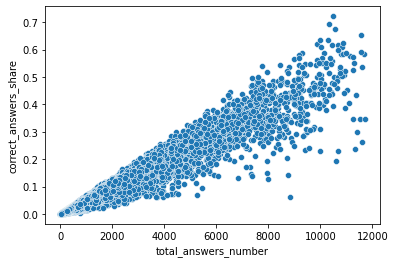

In [58]:
# Выводим scatterplot для зависимости числа правильных ответов от общего числа ответов студента
# В целом видим логичную картину: чем больше студент отвечает, чем больше у него правильных ответов
# Но имеются отдельные студенты, которые делают много неверных попыток и их суммарный балл ниже среднего
# Зависимость примерно линейная

sns.scatterplot(data=users_info,
                x='total_answers_number',
                y='correct_answers_share')

<AxesSubplot:xlabel='max_timestamp', ylabel='correct_answers_share'>

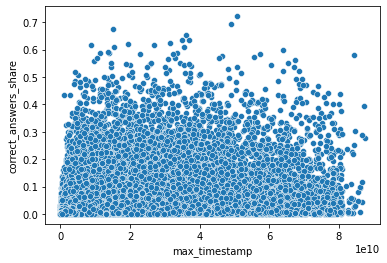

In [59]:
# Выводим scatterplot для зависимости числа правильных ответов от времени, проведенного на платформе
# Явной зависимости не наблюдается
# Предполагаем, что данную характеристику нет смысла использовать при обучении модели

sns.scatterplot(data=users_info,
                x='max_timestamp',
                y='correct_answers_share')

<AxesSubplot:xlabel='mean_prior_elapsed_time', ylabel='correct_answers_share'>

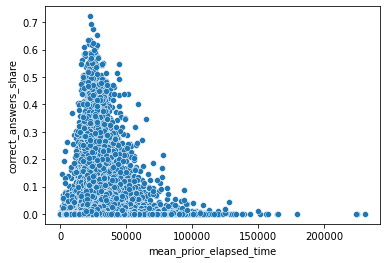

In [60]:
# Выводим scatterplot для зависимости числа правильных ответов от среднего времени ответа на предыдущие вопросы

# Можно отметить, что большинство пользователей с высоким колличеством правльных ответов тратили на ответ
# не более 75сек. Пик для пользователей с максимальным количеством правильных ответов приходится примерно на 25сек

# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.scatterplot(data=users_info,
                x='mean_prior_elapsed_time',
                y='correct_answers_share')

<AxesSubplot:xlabel='mean_prior_explanation', ylabel='correct_answers_share'>

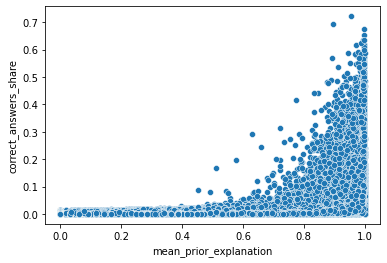

In [61]:
# Выводим scatterplot для зависимости числа правильных ответов от среднего количество просмотров
# объяснения ответов на вопросы предыдущего блока

# Можно отметить, что количество правильных ответов резко возрастает с ростом просмотров, особенно при просмотре 
# больше 70% объяснений

# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.scatterplot(data=users_info,
                x='mean_prior_explanation',
                y='correct_answers_share')

<AxesSubplot:xlabel='mean_attempts', ylabel='correct_answers_share'>

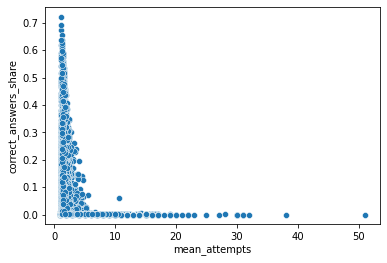

In [62]:
# Вводим столбец, сколько в среднем студенту потребовалось попыток на правильный ответ
# Делаем вывод, что студенты, набирающие значимое количество баллов, делают в среднем не больше 5 попыток
# Предполагаем, что данную характеристику нет смысла использовать при обучении модели

users_info['mean_attempts'] = users_info['total_answers_number'] / users_info['correct_answers_number']
sns.scatterplot(data=users_info,
                x="mean_attempts",
                y="correct_answers_share")

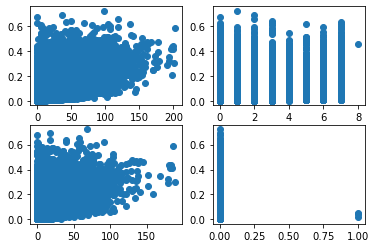

In [63]:
# Выводим 4 scatterplot для зависимости числа правильных ответов от количества просмотров каждого типа лекций
# Можно отметить, что для типов 'lect_type_of_intention' и 'lect_type_of_starter' явной зависимости нет

fig, axs = plt.subplots(2, 2)

axs[0, 0].scatter(users_info['lect_type_of_concept'],
                  users_info['correct_answers_share'])

axs[0, 1].scatter(users_info['lect_type_of_intention'],
                  users_info['correct_answers_share'])

axs[1, 0].scatter(users_info['lect_type_of_solving'],
                  users_info['correct_answers_share'])

axs[1, 1].scatter(users_info['lect_type_of_starter'],
                  users_info['correct_answers_share'])

<AxesSubplot:xlabel='lect_type_of_concept', ylabel='correct_answers_share'>

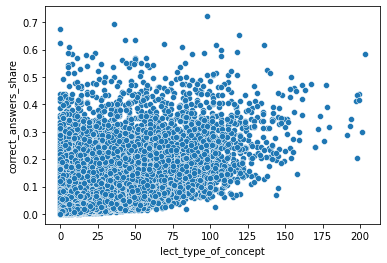

In [64]:
# Выводим отдельно scatterplot для зависимости числа правильных ответов от
# количества просмотров лекций типа 'lect_type_of_concept'

# Можно отметить, что в среднем количество правильных ответов растет с числом просмотренных лекций

sns.scatterplot(data=users_info,
                x='lect_type_of_concept',
                y='correct_answers_share')

<AxesSubplot:xlabel='lect_type_of_concept', ylabel='correct_answers_share'>

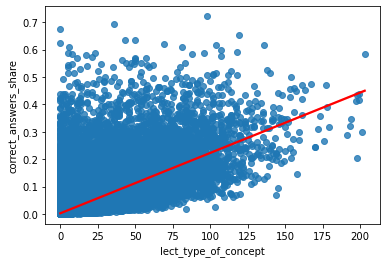

In [65]:
# Выводим отдельно regplot с прямой для линейной регрессии для зависимости числа правильных ответов от
# количества просмотров лекций типа 'lect_type_of_concept'

# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.regplot(data=users_info,
            x='lect_type_of_concept',
            y='correct_answers_share',
            line_kws={"color": "red"})

<AxesSubplot:xlabel='lect_type_of_solving', ylabel='correct_answers_share'>

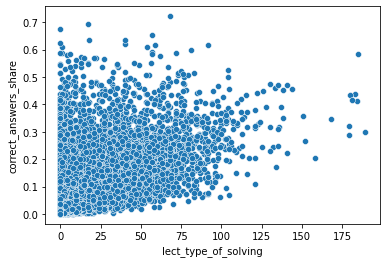

In [66]:
# Выводим отдельно scatterplot для зависимости числа правильных ответов от
# количества просмотров лекций типа 'lect_type_of_solving'

# Можно отметить, что в среднем количество правильных ответов растет с числом просмотренных лекций

sns.scatterplot(data=users_info,
                x='lect_type_of_solving',
                y='correct_answers_share')

<AxesSubplot:xlabel='lect_type_of_solving', ylabel='correct_answers_share'>

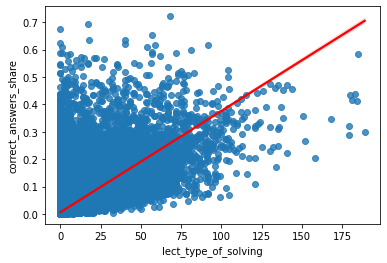

In [67]:
# Выводим отдельно regplot с прямой для линейной регрессии для зависимости числа правильных ответов от
# количества просмотров лекций типа 'lect_type_of_solving'

# Видим, что согласно наклону регрессионной прямой, просмотры 'lect_type_of_solving' влияют на количество
# правильных ответов больше, чем просмотры лекций типа 'lect_type_of_solving'

# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.regplot(data=users_info,
            x='lect_type_of_solving',
            y='correct_answers_share',
            line_kws={"color": "red"})

<AxesSubplot:xlabel='user_total_lect', ylabel='correct_answers_share'>

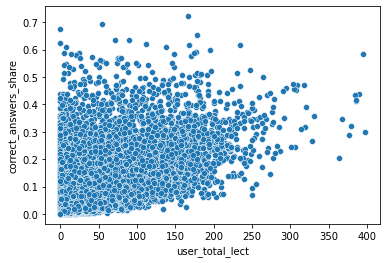

In [68]:
# Выводим отдельно scatterplot для зависимости числа правильных ответов от общего количества просмотренных лекций
# Можно отметить, что в целом количество правильных ответов растет с числом просмотренных лекций

sns.scatterplot(data=users_info,
                x='user_total_lect',
                y='correct_answers_share')

<AxesSubplot:xlabel='user_total_lect', ylabel='correct_answers_share'>

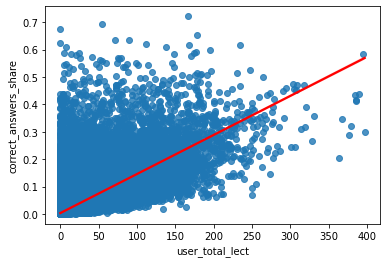

In [69]:
# Выводим отдельно regplot для зависимости числа правильных ответов от общего количества просмотренных лекций
# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.regplot(data=users_info,
            x='user_total_lect',
            y='correct_answers_share',
            line_kws={"color": "red"})

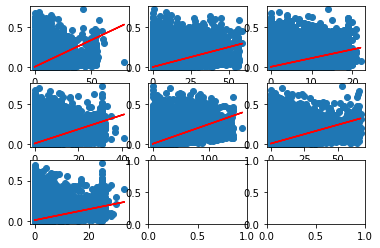

In [70]:
# Выводим 7 scatterplot для зависимости числа правильных ответов от количества просмотров лекций из каждой части
# Для экономии места выводим в виде сетки 3х3
# Выводим регрессионные линии для каждого scatterplot (для демонтрации такой возможности)
# В среднем нельзя сделать вывод, что количество правильных ответов студента растет
# с количеством просмотров лекций в каждой части. Студенты как с высокими баллами, так и с низкими
# приблизительно равномерно распределены вне зависимости от количества просмотренных лекций
# Предполагаем, что данную характеристику нет смысла использовать при обучении модели

fig, axs = plt.subplots(3, 3)

axs[0, 0].scatter(users_info['lect_part_1'], users_info['correct_answers_share'])
m, b = np.polyfit(users_info['lect_part_1'], users_info['correct_answers_share'], 1)
axs[0, 0].plot(users_info['lect_part_1'], m*users_info['lect_part_1']+b, color='red')

axs[0, 1].scatter(users_info['lect_part_2'], users_info['correct_answers_share'])
m, b = np.polyfit(users_info['lect_part_2'], users_info['correct_answers_share'], 1)
axs[0, 1].plot(users_info['lect_part_2'], m*users_info['lect_part_2']+b, color='red')

axs[0, 2].scatter(users_info['lect_part_3'], users_info['correct_answers_share'])
m, b = np.polyfit(users_info['lect_part_3'], users_info['correct_answers_share'], 1)
axs[0, 2].plot(users_info['lect_part_3'], m*users_info['lect_part_3']+b, color='red')

axs[1, 0].scatter(users_info['lect_part_4'], users_info['correct_answers_share'])
m, b = np.polyfit(users_info['lect_part_4'], users_info['correct_answers_share'], 1)
axs[1, 0].plot(users_info['lect_part_4'], m*users_info['lect_part_4']+b, color='red')

axs[1, 1].scatter(users_info['lect_part_5'], users_info['correct_answers_share'])
m, b = np.polyfit(users_info['lect_part_5'], users_info['correct_answers_share'], 1)
axs[1, 1].plot(users_info['lect_part_5'], m*users_info['lect_part_5']+b, color='red')

axs[1, 2].scatter(users_info['lect_part_6'], users_info['correct_answers_share'])
m, b = np.polyfit(users_info['lect_part_6'], users_info['correct_answers_share'], 1)
axs[1, 2].plot(users_info['lect_part_6'], m*users_info['lect_part_6']+b, color='red')

axs[2, 0].scatter(users_info['lect_part_7'], users_info['correct_answers_share'])
m, b = np.polyfit(users_info['lect_part_7'], users_info['correct_answers_share'], 1)
axs[2, 0].plot(users_info['lect_part_7'], m*users_info['lect_part_7']+b, color='red')

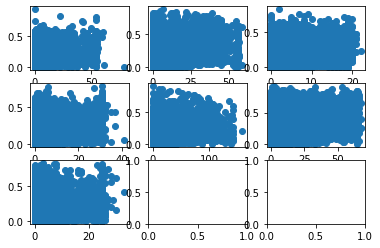

In [71]:
# Выводим 7 scatterplot для зависимости доли правильных ответов от количества просмотров лекций в каждой части
# Для экономии места выводим в виде сетки 3х3
# В среднем нельзя сделать вывод, что доля правильных ответов студента растет
# с количеством просмотров лекций в каждой части. Студенты как с высокими баллами, так и с низкими
# приблизительно равномерно распределены вне зависимости от количества просмотренных лекций
# Предполагаем, что данную характеристику нет смысла использовать при обучении модели

fig, axs = plt.subplots(3, 3)

axs[0, 0].scatter(users_info['lect_part_1'], users_info['correct_answers_share_part_1'])
axs[0, 1].scatter(users_info['lect_part_2'], users_info['correct_answers_share_part_2'])
axs[0, 2].scatter(users_info['lect_part_3'], users_info['correct_answers_share_part_3'])
axs[1, 0].scatter(users_info['lect_part_4'], users_info['correct_answers_share_part_4'])
axs[1, 1].scatter(users_info['lect_part_5'], users_info['correct_answers_share_part_5'])
axs[1, 2].scatter(users_info['lect_part_6'], users_info['correct_answers_share_part_6'])
axs[2, 0].scatter(users_info['lect_part_7'], users_info['correct_answers_share_part_7'])

In [72]:
# Функция, возвращающая столбец номеров квантилей, в которые попадают переданные значения

def get_quantile_number(input_serie, quantiles_number=4):
    res_serie = pd.qcut(input_serie,
                        q=quantiles_number,
                        labels=False)
    return res_serie

In [73]:
# Делим студентов на 4 группы, в зависимости от доли правильных ответов и преобразуем в категорию

users_info['correct_answers_quant'] = get_quantile_number(users_info['correct_answers_share'], 4)
users_info['correct_answers_quant'] = users_info['correct_answers_quant'].astype('category')
users_info['correct_answers_quant'] = users_info['correct_answers_quant'].cat.rename_categories({
    0: '0-25',
    1: '25-50',
    2: '50-75',
    3: '75-100'
})
users_info['correct_answers_quant']

0          50-75
1           0-25
2           0-25
3          50-75
4          50-75
           ...  
393651    75-100
393652    75-100
393653     50-75
393654    75-100
393655     25-50
Name: correct_answers_quant, Length: 393656, dtype: category
Categories (4, object): ['0-25', '25-50', '50-75', '75-100']

<AxesSubplot:xlabel='correct_answers_quant', ylabel='correct_answers_share'>

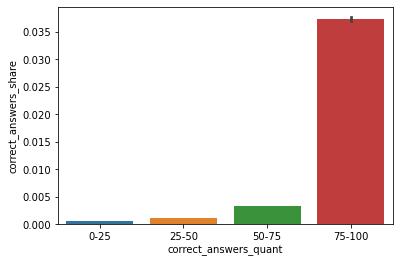

In [74]:
# Выводим результат в виде диаграммы
# Видим, что средний балл у 25% лучших студентов примерно в 10 раз выше, чем у следующих 25%

sns.barplot(data=users_info,
            x="correct_answers_quant",
            y="correct_answers_share")

In [75]:
# Пишем функцию для генерации флага по условию "больше заданного значения"
# Добавляем флаги, что студент прослушал больше половины всех лекций и что студент прослушал хотя бы одну лекцию

def check_is_higher(input_serie, boundary_value):
    if input_serie > boundary_value:
        return 1
    else:
        return 0
    
users_info['more_than_half_lectures'] = users_info['user_total_lect'].apply(check_is_higher,
                                                                            boundary_value=number_of_lectures / 2.0)
users_info['more_than_half_lectures'] = users_info['more_than_half_lectures'].astype('category')
users_info['more_than_half_lectures'] = users_info['more_than_half_lectures'].cat.rename_categories({
    0: 'less_than_half',
    1: 'more_than_half'  
})

users_info['at_least_one_lecture'] = users_info['user_total_lect'].apply(check_is_higher,
                                                                          boundary_value=1)
users_info['at_least_one_lecture'] = users_info['at_least_one_lecture'].astype('category')
users_info['at_least_one_lecture'] = users_info['at_least_one_lecture'].cat.rename_categories({
    0: 'no_lectures',
    1: 'lectures'
})

In [76]:
# Создаем сабсет с лекциями для частей
# Пишем функцию, считающую, прослушал ли студент хотя бы одну лекцию в каждой части
# Вводим соответствующий флаг

users_info['at_least_one_lecture_each_part'] = users_info['lect_part_1'].apply(check_is_higher,
                                                                          boundary_value=1)
users_info['at_least_one_lecture_each_part'] += users_info['lect_part_2'].apply(check_is_higher,
                                                                          boundary_value=1)
users_info['at_least_one_lecture_each_part'] += users_info['lect_part_3'].apply(check_is_higher,
                                                                          boundary_value=1)
users_info['at_least_one_lecture_each_part'] += users_info['lect_part_4'].apply(check_is_higher,
                                                                          boundary_value=1)
users_info['at_least_one_lecture_each_part'] += users_info['lect_part_5'].apply(check_is_higher,
                                                                          boundary_value=1)
users_info['at_least_one_lecture_each_part'] += users_info['lect_part_6'].apply(check_is_higher,
                                                                          boundary_value=1)
users_info['at_least_one_lecture_each_part'] += users_info['lect_part_7'].apply(check_is_higher,
                                                                          boundary_value=1)
users_info['at_least_one_lecture_each_part'] = users_info['at_least_one_lecture_each_part'].apply(check_is_higher,
                                                                          boundary_value=3)
users_info['at_least_one_lecture_each_part'] = users_info['at_least_one_lecture_each_part'].astype('category')
users_info['at_least_one_lecture_each_part'] = users_info['at_least_one_lecture_each_part'].cat.rename_categories({
    0: 'no_lectures',
    1: 'lectures'
})

<AxesSubplot:xlabel='correct_answers_quant', ylabel='correct_answers_share'>

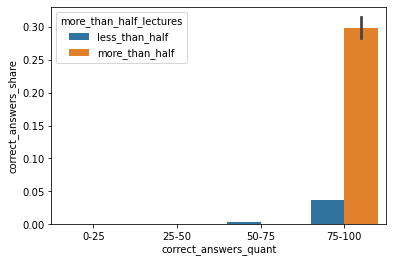

In [77]:
# Выводим в виде диаграммы средний балл студентов для каждого из квартилей в зависимости от просмотра 

# Видим, что в случае 25% наиболее успешных студентов средний балл тех, кто посмотрел больше половины лекций
# в 8 раз выше, чем у тех, кто посмотрел меньше половины
# В других группах студентов, посмотревших больше половины лекций нет
# Можно сделать вывод, что просмотр больше половины лекций значительно влияет на количество правильных ответов

sns.barplot(data=users_info,
            x="correct_answers_quant",
            y="correct_answers_share",
            hue="more_than_half_lectures")

<AxesSubplot:xlabel='more_than_half_lectures', ylabel='correct_answers_share'>

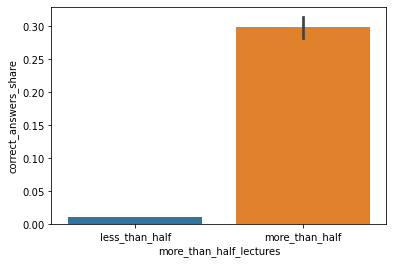

In [78]:
# Дополнительно выводим в виде диаграммы средний балл всех студентов в зависимости от просмотра половины лекций
# Видим, что средний балл значительно выше у тех, кто просмотрел больше половины лекций
# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.barplot(data=users_info,
            x="more_than_half_lectures",
            y="correct_answers_share")

<AxesSubplot:xlabel='correct_answers_quant', ylabel='correct_answers_share'>

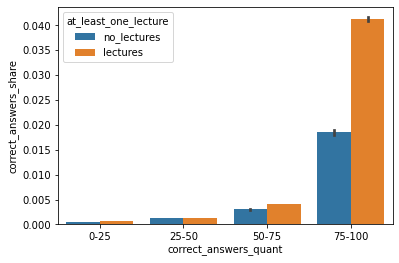

In [79]:
# Выводим в виде диаграммы средний балл студентов для каждого из квартилей в зависимости от просмотра хотя бы одной лекции

# Видим, что для 1, 3 и 4 квартилей средний балл выше у тех, кто посмотрел хотя бы одну лекцию
# Для 2 квартиля значимой разницы нет
# При этом отметим, что в числе студентов, попавших в число 25% лучших, есть те, кто не смотрел ни одной лекции

sns.barplot(data=users_info,
            x="correct_answers_quant",
            y="correct_answers_share",
            hue="at_least_one_lecture")

<AxesSubplot:xlabel='at_least_one_lecture', ylabel='correct_answers_share'>

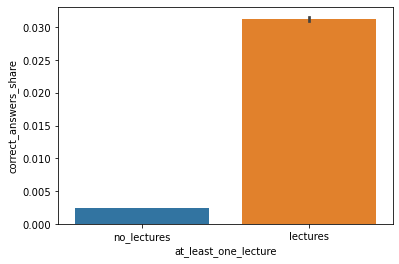

In [80]:
# Дополнительно выводим в виде диаграммы средний балл всех студентов в зависимости от просмотра хотя бы одной лекции
# Видим, что средний балл в 8-9 раз выше у тех, кто просмотрел хотя бы одну лекцию
# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.barplot(data=users_info,
            x="at_least_one_lecture",
            y="correct_answers_share")

<AxesSubplot:xlabel='correct_answers_quant', ylabel='correct_answers_share'>

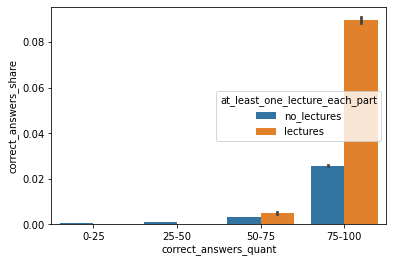

In [81]:
# Выводим в виде диаграммы средний балл студентов для каждого из квартилей в зависимости от просмотра
# хотя бы одной лекции в каждой части

# Видим, что для 3 и 4 квартилей средний балл выше у тех, кто посмотрел хотя бы одну лекцию в каждой части

# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.barplot(data=users_info,
            x="correct_answers_quant",
            y="correct_answers_share",
            hue="at_least_one_lecture_each_part")

<AxesSubplot:xlabel='at_least_one_lecture_each_part', ylabel='correct_answers_share'>

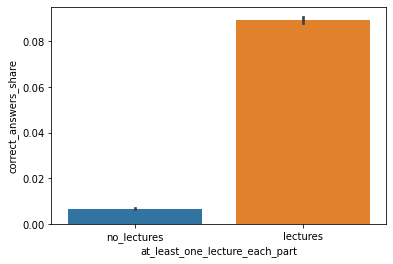

In [82]:
# Дополнительно выводим в виде диаграммы средний балл всех студентов в зависимости от просмотра
# хотя бы одной лекции в каждой части

# Видим, что средний балл в 12 раз выше у тех, кто просмотрел хотя бы одну лекцию
# Предполагаем, что данную характеристику можно использовать при обучении модели

sns.barplot(data=users_info,
            x="at_least_one_lecture_each_part",
            y="correct_answers_share")

In [83]:
# Делим студентов на 2 группы, в зависимости от доли правильных ответов для групп 1, 2 и 5
# В остальных группах доля правильных ответов у большинства студентов слишком маленькая и на две группы
# разделить не получается

for i in [1, 2, 5]:
    column_name = 'correct_answers_share_part_' + str(i)
    users_info[column_name + '_quant'] = get_quantile_number(
        users_info[column_name],
        2)
    users_info[column_name + '_quant'] = users_info[column_name + '_quant'].astype('category')
    users_info[column_name + '_quant'] = users_info[column_name + '_quant'].cat.rename_categories({
        0: '0-50',
        1: '50-100'
    }
    )

C:\Users\Yury\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


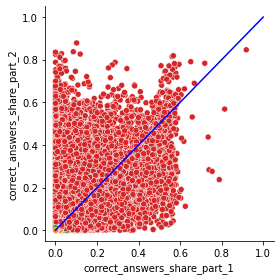

In [84]:
# Попробуем проанализировать, влияет ли каким-то образом доля правильных ответов в первой части
# на долю правильных ответов во второй. Строим scatterplot и проводим линию под углом 45 градусов.

# Если есть прямая зависимость, точки должны лежать близко к линии: тот, кто хорошо отвечал в первой части,
# будет хорошо отвечать и во второй

# В данном случае такой зависимости нет, точки приблизительно равномерно распределены вокруг линии.
# Предполагаем, что нет смысла учитывать влияние доли правильных ответов в прошлых частях при обучении модели

X_plot = np.linspace(0, 1, 10)
Y_plot = X_plot
g = sns.FacetGrid(users_info, size=4)
g = g.map(sns.scatterplot,
          data=users_info,
          x='correct_answers_share_part_1',
          y='correct_answers_share_part_2',
          hue='correct_answers_quant')
plt.plot(X_plot, Y_plot, color='b')
plt.show()

C:\Users\Yury\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


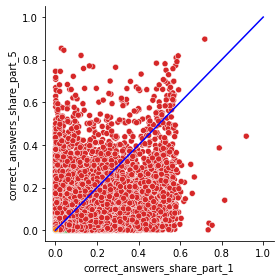

In [85]:
# Для иллюстрации строим аналогичный график для частей 1 и 5

g = sns.FacetGrid(users_info, size=4)
g = g.map(sns.scatterplot,
          data=users_info,
          x='correct_answers_share_part_1',
          y='correct_answers_share_part_5',
          hue='correct_answers_quant')
plt.plot(X_plot, Y_plot, color='b')
plt.show()

C:\Users\Yury\anaconda3\lib\site-packages\seaborn\axisgrid.py:337: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


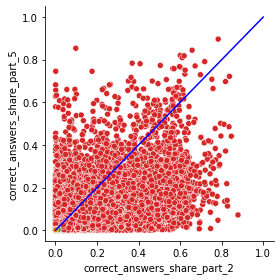

In [86]:
# Для иллюстрации строим аналогичный график для частей 2 и 5
# Здесь виден небольшой перекос в сторону уменьшения доли правильных ответов в части 5 у тех,
# кто хорошо отвечал в части 2

g = sns.FacetGrid(users_info, size=4)
g = g.map(sns.scatterplot,
          data=users_info,
          x='correct_answers_share_part_2',
          y='correct_answers_share_part_5',
          hue='correct_answers_quant')
plt.plot(X_plot, Y_plot, color='b')
plt.show()